Gets self efficacy and response efficacy score

In [1]:
library(tidyverse)
library(here)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Efficacy_scores


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date




Preprocessing
==============

Efficacy scores were collected in:
- every 3 days evening questionnaires (!! bug in the plateform, question was presented every day for some participants -> need to work out which and take every 3 day measures)

- baseline and followup efficacy - for EEG participants

- screening and followup questionnaire - get scores for online participants

- Participants who did the baseline and followup Efficacy score on the same survey as the every 3 days one: 
562, 477, 703, 786

In [2]:
#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_eff_score.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence


every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


# condition file
cond <- read_csv(cond_file)

#Associate online pp baseline efficacy score with their study id:


#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 
qualtrics<-rename(qualtrics, Response.ID = ResponseId)

remove(baseline_online)

# join pp_ids with qualtrics data
baseline_online<- left_join(pp_ids, qualtrics)

# join with study id
baseline_online <- left_join(study_id, baseline_online)

# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)

#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1, 
                  quit_int = Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1
                 # quit_int = Q5
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                       r_eff1 = Q88_1, r_eff2= Q88_2, 
                       s_eff1 = Q90_1, s_eff2 = Q90_2, s_eff3= Q90_3, 
                       hope=Q92_1
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                       r_eff1 = Q108_1, r_eff2= Q108_2, 
                       s_eff1 = Q110_1.1, s_eff2 = Q110_2.1, s_eff3= Q110_3.1, 
                       hope=Q112_1.1
                           )

            
baseline_online$ID<-as.factor(baseline_online$ID)

Joining, by = "Response.ID"

Joining, by = "Screening.ID"



Create one long dataset collating all data

In [3]:
# add a "session" column

every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

get sessions for the baseline-followup dataset
  

In [4]:
# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number()) %>% 
        ungroup()
        
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, r_eff1:hope, type, completed)
every3days_scores <-select(every3days_scores, ID, date, r_eff1:hope, type, completed)
followup_online<-select(followup_online, ID, date, r_eff1:hope, type, completed)
baseline_online<-select(baseline_online, ID, date, r_eff1:hope, type, completed)

# get only completed surveys
every3days_scores<-filter(every3days_scores, completed=='True')

baseline_followup_eeg<-filter(baseline_followup_eeg, completed=='True')

followup_online<-filter(followup_online, completed=='True')
baseline_online<-filter(baseline_online, completed=='True')

Do some custom change to fit special cases

In [5]:
#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n())) %>% 
  ungroup()  

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1)) %>% 
  ungroup()  


# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

# get IDs of pp who did the survey every day instead of every 3 days

# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  distinct(ID) %>% 
  ungroup()  

  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

baseline_online<-filter(baseline_online, completed=='True')

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”
Warning message:
“Column `type` joining factor and character vector, coercing into character vector”
Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [6]:
# remove extra every 3 days rows
baseline_followup_eeg<-baseline_followup_eeg %>% filter(type=='baseline'|type=='followup')

In [7]:
eff_scores<-bind_rows(baseline_followup_eeg, df9)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [8]:

tmp<-bind_rows(eff_scores, followup_online) 

tmp2<- bind_rows(tmp, baseline_online)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [9]:
remove(eff_scores)
eff_scores<-tmp2

In [10]:
eff_scores<-tail(eff_scores, -2)
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number()) %>% 
        ungroup()
        

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day,check
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0,1
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0,1
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0,1
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0,1
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0,1
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0,1
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0,1
729,2019-10-22 13:21:12,67,31,15,5,55,18,baseline,True,0,1
562,2019-10-23 16:51:53,61,38,28,10,80,44,baseline,True,0,1


In [12]:
eff_scores

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0
729,2019-10-22 13:21:12,67,31,15,5,55,18,baseline,True,0
562,2019-10-23 16:51:53,61,38,28,10,80,44,baseline,True,0


Create one big dataframe assembling all the others

In [19]:
# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

In [ ]:
#get the experiment condition file with all pp IDs only
#cond_sml<-cond %>% select(ID, condition)

In [20]:
eff_scores$ID<-as.factor(eff_scores$ID)

In [ ]:
write_csv(eff_scores, "eff_scores.csv")

In [ ]:
write_csv(cond_sml, "cond_sml.csv")

In [21]:
toto<-full_join(cond, eff_scores)

Joining, by = "ID"

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”


In [ ]:

# merge cond and eff files to get information about participants condition
#eff_scores<-inner_join(cond,eff_scores, by= 'ID')

In [22]:
remove(eff_scores)
eff_scores<-toto

In [23]:
colnames(eff_scores)

[1] "ID"                       "START"                   
 [3] "day_msg"                  "condition"               
 [5] "EEG"                      "Finished"                
 [7] "removed"                  "Good"                    
 [9] "Interview"                "Notes"                   
[11] "No.Compliance"            "Email.reminder.poor.perf"
[13] "eve_msg"                  "ev3days"                 
[15] "run_for"                  "day_msg_exp"             
[17] "eve_msg_exp"              "day_diff_exp_real"       
[19] "eve_diff_exp_real"        "most_recent"             
[21] "NAME"                     "EMAIL"                   
[23] "PHONE"                    "date"                    
[25] "r_eff1"                   "r_eff2"                  
[27] "s_eff1"                   "s_eff2"                  
[29] "s_eff3"                   "hope"                    
[31] "type"                     "completed"               
[33] "n_day"

In [ ]:
eff_scores$type


In [24]:
#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")


#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)

Filter participants based on survey completion criteria

In [ ]:
#filter to keep participants not removed
#eff_scores<-eff_scores%>%filter(removed == 0)

In [26]:
# filter to keep participants who did at least 80% of surveys
eff_scores<-eff_scores%>%filter(Good == 1)

Do a check of for missing values in the data


In [ ]:
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

In [ ]:
missing.values

Look at why we have condition with missing values


In [ ]:
which(is.na(eff_scores$condition))

In [27]:
# remove these lines 

eff_scores<-drop_na(eff_scores, condition)

In [28]:
df<-eff_scores


 Compute response and self efficacy scores:
--------------------------------------------

get the mean of all individual scores in each condition for each day:

- define days 1-2-3 etc.
- check for those pp who did baseline and followup (IDs 562, 477, 703, 786)
- find participants with a maximum of 9 n_day
- find participants with more than 9 n_day entries
- take only only every 3 days: 1, 6, 9, 12, 15, 18, 21

create new dataset:  
- count how many of each day per condition


In [29]:
# transform the columns for response and self efficacy that were charactuers in numeric tyoe           
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition, -type) 




Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [33]:
df<-select(df, -'EEG', -'Good',  -'removed', -'Finished', -'Interview', -'Notes', -"completed" )

In [41]:
df<-select(df, -'START', -'day_msg',  -'No.Compliance', -'Email.reminder.poor.perf', -'eve_msg', -'ev3days', -'run_for', -'day_msg_exp', -'eve_msg_exp', -'day_diff_exp_real', -'eve_diff_exp_real', -'most_recent', -'NAME', -'EMAIL', -'PHONE', -'date')

count how many of each day per condition

Saving 6.67 x 6.67 in image



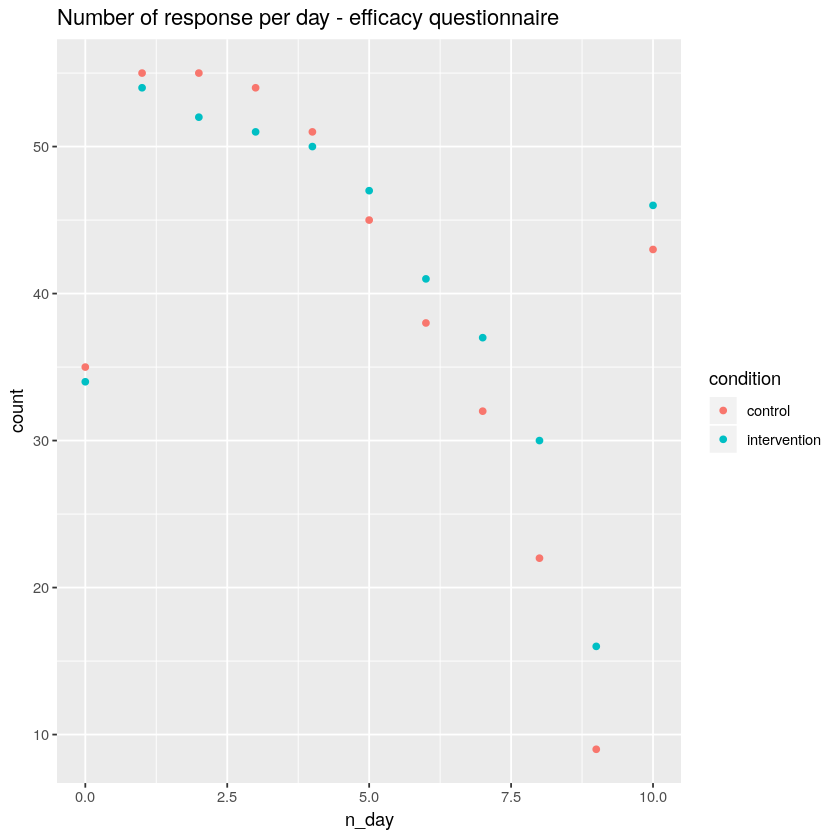

In [34]:
n_rep <- df %>% group_by(condition, n_day) %>%
 summarize(count=n()) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()


# plot
ggplot(data= n_rep, aes(x = n_day, y=count)) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Number of response per day - efficacy questionnaire")
  ggsave('nresp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

Work on mean scores

In [35]:
# compute total score for each measure for each day and each participant

df <- df %>% group_by(ID, n_day) %>% 
  mutate(total_re= sum(r_eff1, r_eff2), 
         total_se= sum(s_eff1, s_eff2, s_eff3)
         ) %>% 
    ungroup()
    

In [36]:
df<-select(df, -"r_eff1", -"r_eff2", -"s_eff1", -"s_eff2", -"s_eff3")

In [37]:
df<- rename(df, total_hope=hope)

In [48]:
df

ID,condition,total_hope,type,n_day,total_re,total_se
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
702,intervention,73,every3days,1,140,210
702,intervention,76,every3days,2,200,214
702,intervention,75,every3days,3,152,257
702,intervention,76,every3days,4,162,208
702,intervention,80,every3days,5,170,266
702,intervention,84,every3days,6,184,271
702,intervention,91,every3days,7,196,275
702,intervention,100,every3days,8,180,284
702,intervention,NA,followup,10,NA,NA


In [44]:
# turn df into long format 
df_long<-df %>% 
  pivot_longer(
    -c('ID', 'condition','type', 'n_day'),  
    names_to = c(".value", "score"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

In [45]:
df_long

ID,condition,type,n_day,score,total
<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>
702,intervention,every3days,1,hope,73
702,intervention,every3days,1,re,140
702,intervention,every3days,1,se,210
702,intervention,every3days,2,hope,76
702,intervention,every3days,2,re,200
702,intervention,every3days,2,se,214
702,intervention,every3days,3,hope,75
702,intervention,every3days,3,re,152
702,intervention,every3days,3,se,257


In [46]:
# compute summary statistics per condition per day for each score
summary_df <- df_long %>%
  group_by(condition, n_day, score) %>%
  summarise(mean.total = mean(total),
            sd.total= sd(total), count = n(),
            se.mean = sd.total/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

In [47]:
summary_df

condition,n_day,score,mean.total,sd.total,count,se.mean,ci.mean
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,0,hope,25.15385,19.50575,13,5.409922,-0.3464015
control,0,re,127.30769,45.57299,13,12.639673,-0.8093280
control,0,se,100.53846,76.47398,13,21.210065,-1.3580968
control,1,hope,37.92727,24.45847,55,3.297980,-0.2077691
control,1,re,131.66667,42.82787,54,5.828135,-0.3671983
control,1,se,112.36364,73.68184,55,9.935257,-0.6259103
control,2,hope,37.00000,24.23343,55,3.267635,-0.2058574
control,2,re,132.38889,48.10971,54,6.546902,-0.4124838
control,2,se,116.61818,72.65405,55,9.796670,-0.6171794



- 3. Compute mean response and self efficacy score for each day for each pp

- 4. plot
!!! different number of data points per paricipant !!!

# test plot

https://stackoverflow.com/questions/55262229/how-to-use-geom-errorbar-with-facet-wrap-in-ggplot2

In [ ]:
# IGNORE !!!

# compute mean total of response and self efficacy score for each day for each condition
#m_scores <- df %>% group_by(condition, n_day) %>% 
#  summarise(mean_re= mean(total_re,na.rm=TRUE), 
#            mean_se=mean(total_se, na.rm=TRUE), 
#            mean_hope = mean(hope, na.rm=TRUE), 
#           sd_re= sd(total_re,na.rm=TRUE), 
#           sd_se=sd(total_se, na.rm=TRUE), 
#            sd_hope = sd(hope, na.rm=TRUE), 
#             n=n()       
#           ) %>% 
#   mutate(se_re = sd_re/sqrt(n), 
#         se_se = sd_se/sqrt(n), 
#         se_hope = sd_hope/sqrt(n), 
 #         ci_re = qt(1-(1-0.95/2),n-1)*se_re, 
 #        ci_se = qt(1-(1-0.95/2),n-1)*se_se, 
 #        ci_hope = qt(1-(1-0.95/2),n-1)*se_hope
 #        ) %>% 
 #   ungroup()

#m_scores <- left_join(m_scores, n_rep)

In [ ]:
#write_csv(m_scores, "summary_stats.csv")

Plot response and self efficacy scores

In [ ]:
#m_scores %>% gather("type", "score", 3:4 ) %>% 
#  ggplot(data=., mapping=aes(x= n_day, y=score)) +
#         geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+
#        facet_wrap(~type)+
  #geom_errorbar(aes(ymin=score-ci, ymax=score+ci))+  
#  geom_smooth(se=FALSE)+
#  ggtitle("Mean scores for response and self efficacy per day per condition")
  
#  ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
summary_df

In [49]:
test_eff<-summary_df %>% 
        filter(score=="re" | score=="se") 

Saving 6.67 x 6.67 in image



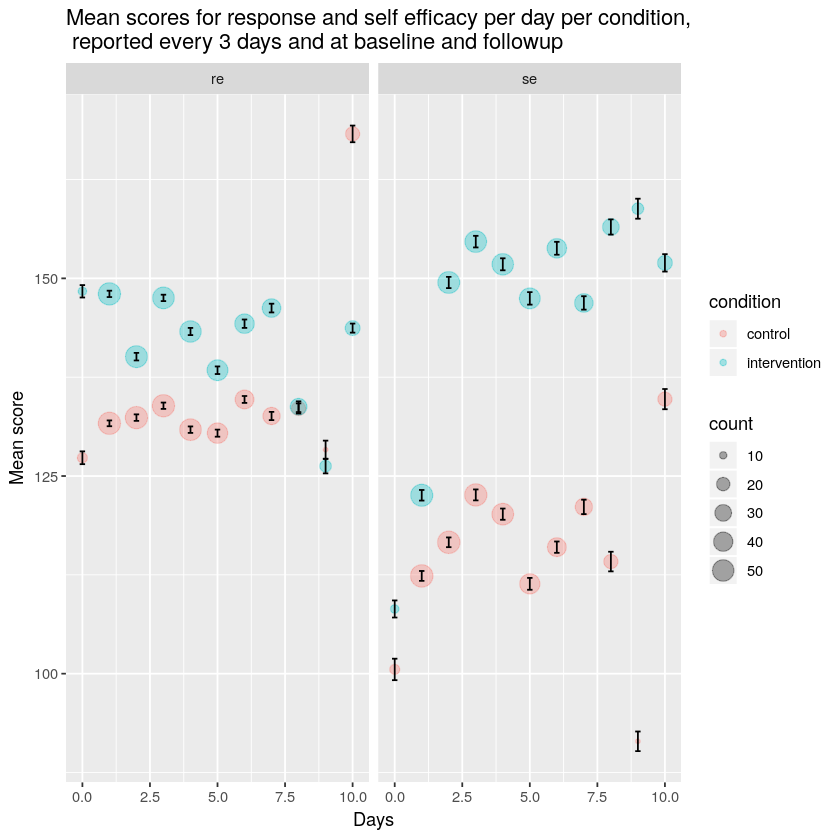

In [54]:
gs1 <- ggplot(test_eff, aes(x=n_day, y=mean.total)) + 
       geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Days")+ylab("Mean score")+
    ggtitle("Mean scores for response and self efficacy per day per condition,\n reported every 3 days and at baseline and followup")
gs1  
ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)

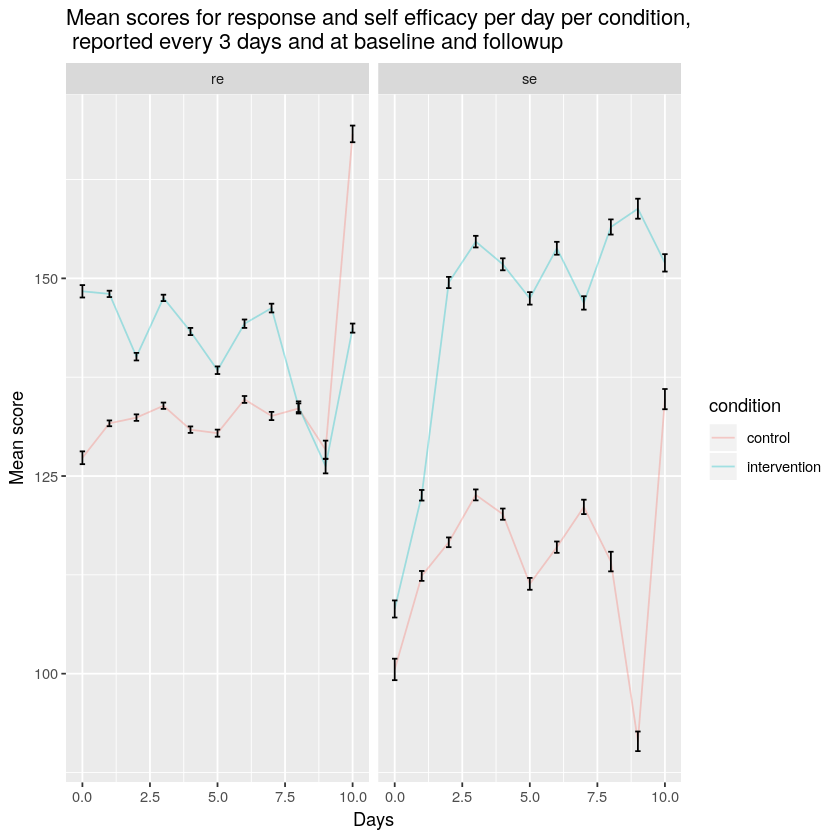

In [56]:
# only plot before and after
gs2 <- ggplot(test_eff, aes(x=n_day, y=mean.total)) + 
       geom_line(mapping = aes(colour=condition), alpha=1/3)+ 
       facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Days")+ylab("Mean score")+
    ggtitle("Mean scores for response and self efficacy per day per condition,\n reported every 3 days and at baseline and followup")
gs2 
#ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)

In [ ]:
# Add regression lines
ggplot(test_eff, aes(x=n_day, y=mean.total, color=condition)) +
  geom_point() + 
 facet_wrap(~score)+
  geom_smooth(method=lm, se=TRUE, fullrange=TRUE)


Plot hope score

In [57]:
test_hope<-summary_df %>% 
        filter(score=="hope")  

In [60]:
test_hope

condition,n_day,score,mean.total,sd.total,count,se.mean,ci.mean
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,0,hope,25.15385,19.50575,13,5.409922,-0.3464015
control,1,hope,37.92727,24.45847,55,3.297980,-0.2077691
control,2,hope,37.00000,24.23343,55,3.267635,-0.2058574
control,3,hope,37.75926,26.05505,54,3.545643,-0.2233912
control,4,hope,39.00000,24.53650,51,3.435798,-0.2165320
control,5,hope,37.86667,25.75814,45,3.839797,-0.2421586
control,6,hope,38.65789,23.80697,38,3.862000,-0.2438218
control,7,hope,38.03125,25.79508,32,4.559969,-0.2882651
control,8,hope,36.54545,29.13471,22,6.211540,-0.3941874


Saving 6.67 x 6.67 in image



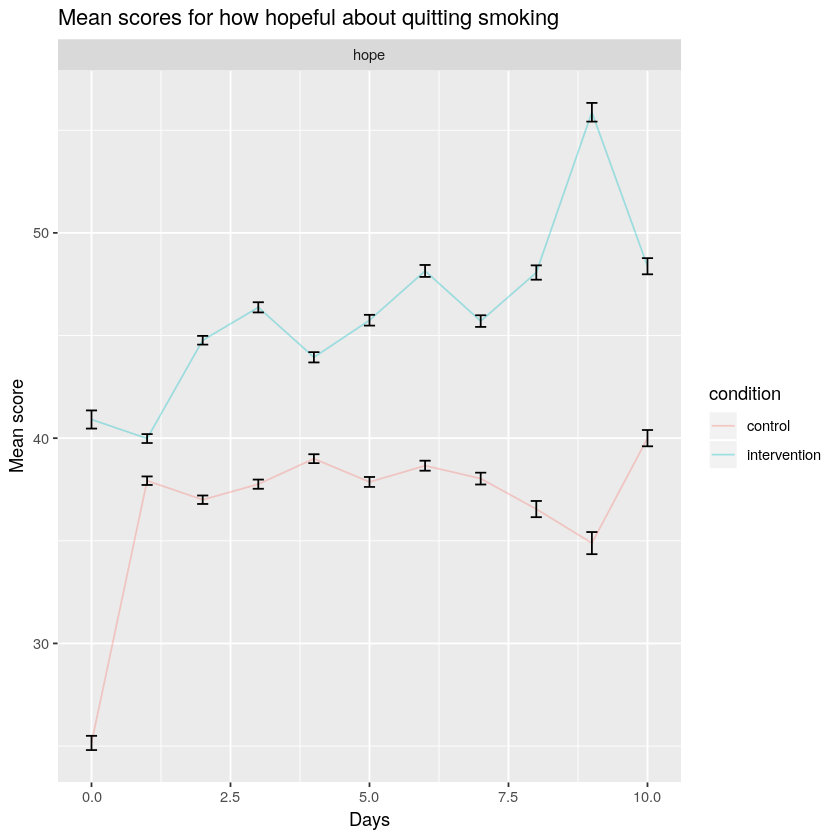

In [59]:

ggplot(data=test_hope, mapping=aes(x= n_day, y=mean.total)) +
      geom_line(mapping = aes(colour=condition), alpha=1/3)+ 
       facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Days")+ylab("Mean score")+
   ggtitle("Mean scores for how hopeful about quitting smoking")

  ggsave('hope_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


Make raincloud plots

In [ ]:
library(cowplot)
library(readr)
#library(dplyr)

In [ ]:
### This script creates an R function to generate raincloud plots, then simulates
### data for plots. If using for your own data, you only need lines 1-80.
### It relies largely on code previously written by David Robinson
### (https://gist.github.com/dgrtwo/eb7750e74997891d7c20)
### and the package ggplot2 by Hadley Wickham

# Check if required packages are installed ----
packages <- c("cowplot", "readr", "ggplot2", "dplyr", "lavaan", "smooth", "Hmisc")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))
}

# Load packages ----
#library(ggplot2)

# Defining the geom_flat_violin function ----
# Note: the below code modifies the
# existing github page by removing a parenthesis in line 50

"%||%" <- function(a, b) {
  if (!is.null(a)) a else b
}

geom_flat_violin <- function(mapping = NULL, data = NULL, stat = "ydensity",
                             position = "dodge", trim = TRUE, scale = "area",
                             show.legend = NA, inherit.aes = TRUE, ...) {
  layer(
    data = data,
    mapping = mapping,
    stat = stat,
    geom = GeomFlatViolin,
    position = position,
    show.legend = show.legend,
    inherit.aes = inherit.aes,
    params = list(
      trim = trim,
      scale = scale,
      ...
    )
  )
}

#' @rdname ggplot2-ggproto
#' @format NULL
#' @usage NULL
#' @export
GeomFlatViolin <-
  ggproto("GeomFlatViolin", Geom,
    setup_data = function(data, params) {
      data$width <- data$width %||%
        params$width %||% (resolution(data$x, FALSE) * 0.9)

      # ymin, ymax, xmin, and xmax define the bounding rectangle for each group
      data %>%
        group_by(group) %>%
        mutate(
          ymin = min(y),
          ymax = max(y),
          xmin = x,
          xmax = x + width / 2
        )
    },

    draw_group = function(data, panel_scales, coord) {
      # Find the points for the line to go all the way around
      data <- transform(data,
        xminv = x,
        xmaxv = x + violinwidth * (xmax - x)
      )

      # Make sure it's sorted properly to draw the outline
      newdata <- rbind(
        plyr::arrange(transform(data, x = xminv), y),
        plyr::arrange(transform(data, x = xmaxv), -y)
      )

      # Close the polygon: set first and last point the same
      # Needed for coord_polar and such
      newdata <- rbind(newdata, newdata[1, ])
  ggplot2:::ggname("geom_flat_violin", GeomPolygon$draw_panel(newdata, panel_scales, coord))
    }, 
          
    draw_key = draw_key_polygon,

    default_aes = aes(
      weight = 1, colour = "grey20", fill = "white", size = 0.5,
      alpha = NA, linetype = "solid"
    ),

    required_aes = c("x", "y")
  )

In [ ]:
packages <- c("ggplot2", "dplyr", "lavaan", "plyr", "cowplot", "rmarkdown",
"readr", "caTools", "bitops")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
install.packages(setdiff(packages, rownames(installed.packages())))
}

In [ ]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("lavaan")
install.packages("plyr")
install.packages("cowplot")
install.packages("rmarkdown")
install.packages("readr")
install.packages("caTools")
install.packages("bitops")

In [ ]:
test_se<-summary_df %>% 
        filter(score=="se") 

In [ ]:
test_se

In [ ]:
fig<-ggplot(test_se, aes(x=condition, y=mean.total, fill=condition))+
    geom_flat_violin(position=position_nudge(x = .2, y = 0),adjust = .2)+
    geom_point(position = position_jitter(width = .15), size = .25)+
    ylab('Score')+xlab('Group')+coord_flip()+theme_cowplot()+guides(fill = FALSE)+
    ggtitle('Total efficacy score')

In [ ]:
fig

In [ ]:
ggplot(df, aes(x=condition, y=total_se, fill=condition, colour=condition))+
    geom_flat_violin(position=position_nudge(x = .25, y = 0),adjust = 2)+
    geom_point(position = position_jitter(width = .15), size = .25)+
    geom_point(data=m_scores, aes(x=condition, y=mean_se), position = position_nudge(.25), colour = "BLACK")+
    geom_errorbar(data =m_scores, aes(x = condition, y = mean_se, ymin = mean_se-ci_se, ymax = mean_se+ci_se), position = position_nudge(.25), colour = "BLACK", width = 0.1, size = 0.8)+
    
ylab('Score')+xlab('Group')+coord_flip()+theme_cowplot()+guides(fill = FALSE)+
    ggtitle('Total efficacy score')

In [ ]:
ggplot(df, aes(x = total_se, y = n_day , fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = total_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = total_se, fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
  geom_line(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), linetype = 3)+
  geom_point(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), shape = 18) +
  geom_errorbar(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition, ymin = mean_se-sd_se, ymax = mean_se+sd_se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")
  

In [ ]:
ggplot(test_se, aes(x = n_day, y = mean.total , fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = total_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = total_se, fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
  geom_line(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), linetype = 3)+
  geom_point(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), shape = 18) +
  geom_errorbar(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition, ymin = mean_se-sd_se, ymax = mean_se+sd_se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")